## I. Import Libraries and Data

In [1]:
import re
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tpot import TPOTClassifier
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import coo_matrix, hstack
from scipy.sparse import csr_matrix, hstack

from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

#readability
import textstat

#sytax
import nltk

## II. Define Functions

## A. Cleaning and Read Functions

In [2]:
def cleanArticle(string):
    strip_special_chars = re.compile("[^A-Za-z0-9' ]+")
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

def read_perez_dataset(dataset_name):
    
    def remove_numbers(in_str):
        return re.sub(r'[0-9]+', '', in_str)
    
    print("Reading dataset")
    result_data_list = []
    data_dir = PEREZ_DATASET_PATH
    for news_type in ['fake', 'legit']:
        folder = '%s/%s/%s' % (data_dir, dataset_name, news_type)
        for fname in os.listdir(folder):
            result_data = {}
            result_data['dataset_name'] = dataset_name
            result_data['news_type'] = news_type
            if news_type == 'fake':
                result_data['is_fake'] = 1
            else:
                result_data['is_fake'] = 0
            if dataset_name == 'fakeNewsDataset':
                result_data['news_category'] = remove_numbers(fname.split('.')[0])
            result_data['file_name'] = fname
            filepath = os.path.join(folder, fname)
            with open(filepath, 'r', encoding="utf8") as f:
                file_data = f.read().split('\n')
                # Some articles don't have a headline, but only article body.
                if len(file_data) > 1:
                    news_content_data = ' '.join(file_data[2:])
                    result_data['news_headline'] = file_data[0]
                else:
                    news_content_data = file_data[0]
                    result_data['news_headline'] = ''
                result_data['news_content'] = news_content_data
                result_data['news_all'] = ' '.join(file_data[0:])
                result_data_list.append(result_data)
                
    df = pd.DataFrame(result_data_list)
    
    df['news_all_clean'] = df['news_all'].apply(lambda a: cleanArticle(a))
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['is_fake',
                                                               'news_type','file_name'],
                                                               axis = 1), 
                                                        df['is_fake'], 
                                                        test_size=.2, random_state=RANDOM_SEED)
    
    print("Finished reading dataset")
    return df, X_train.reset_index(drop = True), y_train.reset_index(drop = True), X_test.reset_index(drop = True), y_test.reset_index(drop = True)

def model_report(title, y_test, predictions, predictions_proba):

    """
    Output: Classification report, confusion matrix, and ROC curve
    """
    print(title)
    print("---------")
    print(classification_report(y_test, predictions))

    cm = metrics.confusion_matrix(y_test, predictions)
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy: {0}'.format(round(metrics.accuracy_score(y_test, predictions),2))
    plt.title(all_sample_title, size = 15)
    plt.show()
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions_proba)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## B. Linguistic-based feature creators

### 1. Ngram & Punctuation

In [104]:
def pad_punct(s):
    """
    Add padding around specified punctuation.
    """
    s = re.sub('([.,!?():])', r' \1 ', s)
    s = re.sub('\s{2,}', ' ', s)
    return s
def tfidf_vectorizer_custom(train, test, ngram_range):
    """
    Create a tfidf vectorized set for train and test data that counts punctuation.
    Ngram range = (1,3)
    """
    train = train.apply(pad_punct)
    test = test.apply(pad_punct)
    vect = TfidfVectorizer(token_pattern=r"(?u)\b\w\w+\b|!|\.|,|\)|\(|\:|\?|\"|\'", #pattern keep punctuation in vectorizer
                          ngram_range = ngram_range).fit(train)
    vocab = vect.vocabulary_.keys()
    vocab = sorted(vocab, key=len)
    print("Traing data info:")
    print('- Vocabulary len:', len(vect.get_feature_names()))
    print('- Longest phrase:', max(vect.vocabulary_, key=len))
    print('- Smallest 10 phrases:', vocab[0:10])
    print('- Sample of features:',np.array(vect.get_feature_names()))
    train_vectorized = vect.transform(train)
    test_vectorized = vect.transform(test)
    return train_vectorized, test_vectorized, vect.get_feature_names()

### 2. Psycholinguistic features

In [107]:
def LIWC_counter(df1, df_LIWC, train_LIWC):
    """
    Inputs: - Data set with field: news_all_clean
            - Preprocessed LIWC lookup table
    Ouput:  - Data set with 73 additional fields for LIWC count results (normalized over string word count)
    """
    df = df1.copy()
    LIWC_vars = train_LIWC.drop('Word', axis = 1).columns.values
    for i in LIWC_vars:
        df[i] = 0
        words = df_LIWC[df_LIWC[i] == 1]['Word']
        for a in words:
            df[i] = (df[i] + 
                df.news_all_clean.str.count(str(" " + a + " "))  + #free floating word
                df.news_all_clean.str.count(str("^" + a + " ")) +  #start word
                df.news_all_clean.str.count(str(" " + a + "$")))   #end word
        df[i] = df[i] / df.news_all_clean.str.count(" ") #normalize over word count
    return df, LIWC_vars

### 3. Readability

In [196]:
def readability_enricher(df1):
    """
    Input: a dataframe with column "news_all" to be analyzed for a variety of readbility metrics.
    Output: the inputted dataframe, enriched with all readbility metrics (there are a total of 10, one of which is categorical).
    """
    df = df1.copy()
    df_drop = df1.copy()
    df["flesch_reading_ease"]=0.0
    df["smog_index"]=0.0
    df["flesch_kincaid_grade"]=0.0
    df["coleman_liau_index"]=0.0
    df["automated_readability_index"]=0.0
    df["dale_chall_readability_score"]=0.0
    df["difficult_words"]=0.0
    df["linsear_write_formula"]=0.0
    df["gunning_fog"]=0.0
    df["text_standard"]=0.0

    for i in range(df.shape[0]):
        text = df['news_all'].iloc[i]
        df.loc[i,("flesch_reading_ease")]= textstat.flesch_reading_ease(text)
        df.loc[i,("smog_index")]= textstat.smog_index(text)
        df.loc[i,("flesch_kincaid_grade")]= textstat.flesch_kincaid_grade(text)
        df.loc[i,("coleman_liau_index")]= textstat.coleman_liau_index(text)
        df.loc[i,("automated_readability_index")]= textstat.automated_readability_index(text)
        df.loc[i,("dale_chall_readability_score")]= textstat.dale_chall_readability_score(text)
        df.loc[i,("difficult_words")]= textstat.difficult_words(text)
        df.loc[i,("linsear_write_formula")]= textstat.linsear_write_formula(text)
        df.loc[i,("gunning_fog")]= textstat.gunning_fog(text)
        df.loc[i,("text_standard")]= textstat.text_standard(text)
    
    return df, df.drop(df_drop.columns.values, axis = 1).drop(["text_standard"],axis = 1).columns.values

### 4. Syntax

In [6]:
def POS_tagger(text):
    """
    Tag POS using nltk. Return a single "sentence" with the POS of each word treated like a "word."
    """
    tokens = nltk.word_tokenize(text)
    text = nltk.Text(tokens)
    tags = nltk.pos_tag(text)
    return " ".join([i[1] for i in tags])

def POS_enricher(df1):
    """
    Input: a dataframe with column "news_headline" and "news_content".
    Output: the inputted dataframe, with the columns "news_headline_POS" and "news_content_POS" created which are a single sentence with the 
    POS of each word represented as word in that same position.
    """
    df = df1.copy()
    df["news_headline_POS"]=""
    df["news_content_POS"]=""
    
    for i in range(df.shape[0]):
        text_headline = cleanArticle(POS_tagger(df['news_headline'].apply(lambda a: cleanArticle(a)).iloc[i]))
        text_content = cleanArticle(POS_tagger(df['news_content'].apply(lambda a: cleanArticle(a)).iloc[i]))
        
        df.loc[i,("news_headline_POS")]= text_headline
        df.loc[i,("news_content_POS")]= text_content
    
    return df

## III. Read in Data, Define Test/Train Set

In [7]:
RANDOM_SEED = 42
PEREZ_DATASET_PATH = "../data/fakeNewsDatasets_Perez-Rosas2018"
np.random.seed(RANDOM_SEED)
perez_full, train_data, train_labels, test_data, test_labels = read_perez_dataset('fakeNewsDataset')
train_data.head()

Reading dataset
Finished reading dataset


,dataset_name,news_all,news_category,news_content,news_headline,news_all_clean
0,fakeNewsDataset,Real Madrid is willing to pay £100m for Eden H...,sports,"says Ramon Calderon ""Real Madrid are not in a ...",Real Madrid is willing to pay £100m for Eden H...,real madrid is willing to pay 100m for eden ha...
1,fakeNewsDataset,Women arrested three times is Melania Trump ...,polit,(CNN) A lady resembling Presidents Trump's wif...,Women arrested three times is Melania Trump,women arrested three times is melania trump ...
2,fakeNewsDataset,Alec Baldwin says he nearly passed on playing...,entmt,Alec Baldwin has revealed that he almost passe...,Alec Baldwin says he nearly passed on playing...,alec baldwin says he nearly passed on playing...
3,fakeNewsDataset,Will Smith reunites with Fresh Prince Pals to ...,entmt,Will Smith is back together with the cast of T...,Will Smith reunites with Fresh Prince Pals to ...,will smith reunites with fresh prince pals to ...
4,fakeNewsDataset,"Instagram adds two-factor authentication, secu...",tech,Instagram just made your account harder to hac...,"Instagram adds two-factor authentication, secu...",instagram adds twofactor authentication securi...


## IV. Run Train/Test Set through LIWC Rented License

We rented the LIWC dataset (for 30 days), as seen here: https://store5.esellerate.net/store/checkout/CustomLayout.aspx?s=STR6622550055&pc=&page=OnePageMoreInfo.htm&SkuRefNum=SKU48070077205

We downloaded the software, outputted the train/test set, ran the train/test set through the LIWC software, and uploaded the LIWC results.
The software marks words to 73 LIWC categories in a binary format (with an 'X')

In [8]:
#1. FakeNews Dataset
train_data['news_all'].to_csv("train_data_news_all_forLIWC.txt")
test_data['news_all'].to_csv("test_data_news_all_forLIWC.txt")
train_LIWC = pd.read_csv(
    "LIWC2015 Results (train_data_news_all_clean_forLIWC).csv").fillna(0).drop('Unnamed: 74', axis = 1).replace('X',1)
test_LIWC = pd.read_csv(
    "LIWC2015 Results (test_data_news_all_clean_forLIWC).csv").fillna(0).drop('Unnamed: 74', axis = 1).replace('X',1)

#2. Celebrity Dataset
train_data['news_all'].to_csv("train_data_news_all_forLIWC_celeb.txt")
test_data['news_all'].to_csv("test_data_news_all_forLIWC_celeb.txt")
train_LIWC = pd.read_csv(
    "LIWC2015 Results (train_data_news_all_forLIWC_celeb).csv").fillna(0).drop('Unnamed: 74', axis = 1).replace('X',1)
test_LIWC = pd.read_csv(
    "LIWC2015 Results (test_data_news_all_forLIWC_celeb).csv").fillna(0).drop('Unnamed: 74', axis = 1).replace('X',1)

In [9]:
train_LIWC.head()

,Word,function,pronoun,ppron,i,we,you,shehe,they,ipron,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
0,he,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,he'd,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,he's,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,her,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,herself,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
test_LIWC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 74 columns):
Word            3447 non-null object
function        3447 non-null int64
pronoun         3447 non-null int64
ppron           3447 non-null int64
i               3447 non-null int64
we              3447 non-null int64
you             3447 non-null int64
shehe           3447 non-null int64
they            3447 non-null int64
ipron           3447 non-null int64
article         3447 non-null int64
prep            3447 non-null int64
auxverb         3447 non-null int64
adverb          3447 non-null int64
conj            3447 non-null int64
negate          3447 non-null int64
verb            3447 non-null int64
adj             3447 non-null int64
compare         3447 non-null int64
interrog        3447 non-null int64
number          3447 non-null int64
quant           3447 non-null int64
affect          3447 non-null int64
posemo          3447 non-null int64
negemo          3447 non-nul

## IV. Quick Look at Data

In [11]:
train_data['news_all_clean'].iloc[1]

"women arrested  three times is melania trump   cnn a lady resembling presidents trump's wife was arrested on multiple occasions when she was discovered without her makeup on the us secret service near the south grounds of the us treasury building was alerted to a women who looked like the presidents wife running away from the house it didn't take long for the washington metropolitan police department spokesman to announce that it was melania again and they escorted her back to her husband without incident"

In [12]:
print("full perez size: ", perez_full.shape)
print("train size: ",train_labels.shape)

full perez size:  (480, 9)
train size:  (384,)


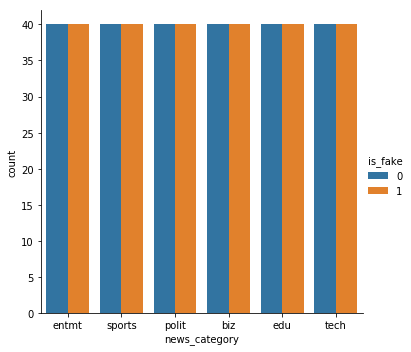

In [13]:
sns.catplot(x="news_category", kind = "count", hue="is_fake", data=perez_full)
plt.show()

In [14]:
perez_full.groupby(['news_category','is_fake']).size()

news_category  is_fake
biz            0          40
               1          40
edu            0          40
               1          40
entmt          0          40
               1          40
polit          0          40
               1          40
sports         0          40
               1          40
tech           0          40
               1          40
dtype: int64

## V. Create Feature-Enriched Training/Testing Datasets

## A. Implement Feature Creating Functions

#### 1. Ngram & Punctuation

In [170]:
train_data_vectorized, test_data_vectorized, ngram_punct_names = tfidf_vectorizer_custom(
    train_data['news_all'], test_data['news_all'], ngram_range = (1,2))
print("train shape:",train_data_vectorized.shape)

Traing data info:
- Vocabulary len: 39803
- Longest phrase: becomeincreasingly difficult
- Smallest 10 phrases: ['"', "'", '.', ':', '(', ')', ',', '?', '!', 'is']
- Sample of features: ['!' '! !' '! "' ... 'zombie apocalypse' 'zuckerberg' 'zuckerberg ,']
train shape: (384, 39803)


#### 2. Psycholinguistic features

In [197]:
train_data_LIWC, train_LIWC_vars = LIWC_counter(train_data, train_LIWC, train_LIWC)
test_data_LIWC, test_LIWC_vars = LIWC_counter(test_data, test_LIWC, train_LIWC)

#### 3. Readability

In [202]:
train_data_readability, train_readability_vars = readability_enricher(train_data)
test_data_readability, test_readability_vars = readability_enricher(test_data)

#### 4. Syntax

In [18]:
train_POS_init = POS_enricher(train_data)
test_POS_init = POS_enricher(test_data)

POS_headline_train_data_vectorized, POS_headline_test_data_vectorized = tfidf_vectorizer_custom(
    train_POS_init['news_headline_POS'], test_POS_init['news_headline_POS'], ngram_range = (1,3))

POS_content_train_data_vectorized, POS_content_test_data_vectorized = tfidf_vectorizer_custom(
    train_POS_init['news_content_POS'], test_POS_init['news_content_POS'], ngram_range = (1,3))

train_POS = hstack([POS_headline_train_data_vectorized, POS_content_train_data_vectorized])
test_POS = hstack([POS_headline_test_data_vectorized, POS_content_test_data_vectorized])

Traing data info:
- Vocabulary len: 1178
- Longest phrase: vbz nns rbr
- Smallest 10 phrases: ["'", 'jj', 'nn', 'to', 'vb', 'cd', 'in', 'rb', 'md', 'cc']
- Sample of features: ["'" "' '" "' ' in" ... 'wrb vbg vbp' 'wrb vbz' 'wrb vbz nn']
Traing data info:
- Vocabulary len: 4500
- Longest phrase: nns vbp vbg
- Smallest 10 phrases: ["'", 'nn', 'jj', 'rb', 'in', 'dt', 'cc', 'md', 'vb', 'to']
- Sample of features: ["'" "' '" "' ' cc" ... 'wrb vbz' 'wrb vbz cd' 'wrb vbz jj']


### B. Unify All Features in Single Dataset

In [182]:
def add_feature(sparse, df_to_sparse, df_ignore):
    """
    Returns sparse feature matrix with added feature.
    """
    return hstack([coo_matrix(df_to_sparse.drop(df_ignore.columns.values, axis = 1)),sparse])

def add_categorical_feature(train_sparse, test_sparse, train_data, test_data, categorical_column):
    """
    Returns sparse feature matrix with added feature by creating a countvectorizer of feature.
    """
    vectcat = CountVectorizer()
    vectcat.fit(train_data[categorical_column].str.replace(' ', ''))
    train_category_vec = vectcat.transform(train_data[categorical_column])
    test_category_vec  = vectcat.transform(test_data[categorical_column])
    train_final = hstack([train_sparse, train_category_vec])
    test_final =  hstack([test_sparse, test_category_vec])
    return train_final, test_final, vectcat.get_feature_names()

In [203]:
#1. Combine ngram and LIWC
train_ngram_LIWC = add_feature(train_data_vectorized, train_data_LIWC, train_data)
test_ngram_LIWC = add_feature(test_data_vectorized, test_data_LIWC, test_data)

#2. Combine readability with ngram and LIWC
train_ngram_LIWC_read = add_feature(train_ngram_LIWC, train_data_readability.drop(["text_standard"],axis = 1), train_data)
test_ngram_LIWC_read = add_feature(test_ngram_LIWC, test_data_readability.drop(["text_standard"],axis = 1), test_data)
train_ngram_LIWC_read, test_ngram_LIWC_read, text_standard_names = add_categorical_feature(
    train_ngram_LIWC_read, test_ngram_LIWC_read, train_data_readability, test_data_readability, "text_standard")

#3. Combine syntax with readability, ngram, and LIWC
train_allfeats = hstack([train_ngram_LIWC_read, train_POS])
test_allfeats = hstack([test_ngram_LIWC_read, test_POS])

#4. Add news category
train_final, test_final, news_category_names = add_categorical_feature(train_ngram_LIWC_read, test_ngram_LIWC_read, 
                                                  train_data, test_data, "news_category")

In [204]:
print("train_ngram_LIWC", train_ngram_LIWC.shape)
print("train_ngram_LIWC_read", train_ngram_LIWC_read.shape)
print("train_allfeats", train_allfeats.shape)
print("train_final", train_final.shape)

train_ngram_LIWC (384, 39876)
train_ngram_LIWC_read (384, 39928)
train_allfeats (384, 45606)
train_final (384, 39934)


## V. Classification Models with Automated Machine Learning (TPOT)

#### 1. Run TPOT Optimizer

In [47]:
pipeline_optimizer = TPOTClassifier(generations=10, population_size=30,
                                    random_state=42, verbosity=2,
                                   config_dict = "TPOT sparse")
pipeline_optimizer.fit(train_final, train_labels) #This takes a couple hours to run

Optimization Progress:  18%|█▊        | 60/330 [04:50<13:38,  3.03s/pipeline]

Generation 1 - Current best internal CV score: 0.7392204286941129


Optimization Progress:  27%|██▋       | 90/330 [06:13<45:18, 11.33s/pipeline]

Generation 2 - Current best internal CV score: 0.7392204286941129


Optimization Progress:  36%|███▋      | 120/330 [09:42<16:15,  4.65s/pipeline]

Generation 3 - Current best internal CV score: 0.7392204286941129


Optimization Progress:  45%|████▌     | 150/330 [14:52<21:58,  7.33s/pipeline]

Generation 4 - Current best internal CV score: 0.7392204286941129


Optimization Progress:  55%|█████▍    | 180/330 [19:24<29:58, 11.99s/pipeline]

Generation 5 - Current best internal CV score: 0.7392204286941129


Optimization Progress:  64%|██████▎   | 210/330 [25:11<33:51, 16.93s/pipeline]

Generation 6 - Current best internal CV score: 0.7417845312582155


Optimization Progress:  73%|███████▎  | 240/330 [34:37<24:20, 16.23s/pipeline]

Generation 7 - Current best internal CV score: 0.7417845312582155


Optimization Progress:  82%|████████▏ | 270/330 [39:00<16:45, 16.76s/pipeline]

Generation 8 - Current best internal CV score: 0.7417845312582155


Optimization Progress:  91%|█████████ | 300/330 [49:38<06:37, 13.24s/pipeline]

Generation 9 - Current best internal CV score: 0.7418844313581155


Generation 10 - Current best internal CV score: 0.7470468128362866

Best pipeline: RandomForestClassifier(RFE(input_matrix, criterion=entropy, max_features=0.3, n_estimators=100, step=0.9500000000000001), bootstrap=True, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=5, min_samples_split=4, n_estimators=100)


TPOTClassifier(config_dict={'tpot.builtins.OneHotEncoder': {'minimum_fraction': [0.05, 0.1, 0.15, 0.2, 0.25]}, 'sklearn.neighbors.KNeighborsClassifier': {'n_neighbors': range(1, 101), 'weights': ['uniform', 'distance'], 'p': [1, 2]}, 'sklearn.ensemble.RandomForestClassifier': {'n_estimators': [100], 'criterion': [...0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), 'min_child_weight': range(1, 21), 'nthread': [1]}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        early_stop=None, generations=10, max_eval_time_mins=5,
        max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
        offspring_size=30, periodic_checkpoint_folder=None,
        population_size=30, random_state=42, scoring=None, subsample=1.0,
        verbosity=2, warm_start=False)

#### 2. Output TPOT Algorithm

In [48]:
pipeline_optimizer.export('tpot_all_feats-nosyntax.py')

True

#### 3. Implement TPOT Algorithm

In [208]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

exported_pipeline = RandomForestClassifier(bootstrap=True, criterion="gini", 
                                           max_features=1.0, min_samples_leaf=15, 
                                           min_samples_split=6, n_estimators=300,
                                          random_state = 1)

exported_pipeline.fit(train_final, train_labels)
ORIG_results = exported_pipeline.predict(test_final)
ORIG_proba = exported_pipeline.predict_proba(test_final)
print("accuracy on original test set: ",np.mean(ORIG_results == test_labels))

accuracy on original test set:  0.7708333333333334


#### 4. Output TPOT Model Report

Original Test Set Report
---------
             precision    recall  f1-score   support

          0       0.76      0.80      0.78        49
          1       0.78      0.74      0.76        47

avg / total       0.77      0.77      0.77        96



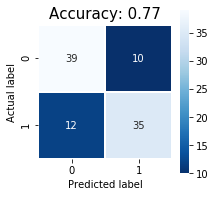

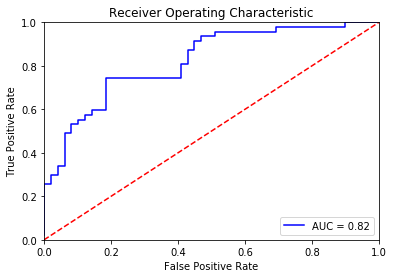

In [209]:
model_report("Original Test Set Report", test_labels, ORIG_results, ORIG_proba[:,1])

#### 5. Analyze Correct/Incorrect Predictions

In [216]:
review_test = test_data
review_test['actual'] = test_labels
review_test['predicted'] = ORIG_results
review_test["correct_prediction?"] = review_test.actual == review_test.predicted

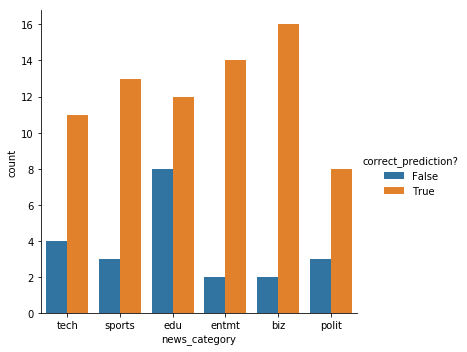

In [217]:
sns.catplot(x="news_category", kind = "count", hue="correct_prediction?", data = review_test)
plt.show()

#### 6. Analyze Feature Importance

In [224]:
print("Feature Names:", 
      len(ngram_punct_names) + 
      len(train_LIWC_vars.tolist()) + 
      len(train_readability_vars.tolist()) +
      len(text_standard_names) +
      len(news_category_names))
feature_names = ngram_punct_names + train_LIWC_vars.tolist() + train_readability_vars.tolist() +text_standard_names + news_category_names
print("Tracked Feature Name Shape:", len(feature_names))
print("Training Data Shape:", train_final.shape)

Feature Names: 39934
Tracked Feature Name Shape: 39934
Training Data Shape: (384, 39934)


In [231]:
importances = exported_pipeline.feature_importances_
std = np.std([tree.feature_importances_ for tree in exported_pipeline.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(50):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

Feature ranking:
1. , bombardier (0.220131)
2. ! like (0.194007)
3. " ' (0.047374)
4. ! here (0.038496)
5. salary (0.032420)
6. on imdb (0.030742)
7. ! ' (0.019694)
8. ' champion (0.018042)
9. it stands (0.016990)
10. ! as (0.015826)
11. " button (0.013073)
12. " bonehead (0.011573)
13. be little (0.011448)
14. " any (0.009361)
15. have second (0.008667)
16. ! (0.008243)
17. for everybody (0.007975)
18. " : (0.007957)
19. " brexit (0.007894)
20. alumni (0.007690)
21. " appreciate (0.007104)
22. ! " (0.007039)
23. " brewdog (0.006923)
24. " dumb (0.006514)
25. ! it (0.006331)
26. " actress (0.006276)
27. " brands (0.005949)
28. " an (0.005655)
29. order to (0.005509)
30. ! ! (0.005189)
31. " amazing (0.005143)
32. in center (0.005118)
33. " british (0.005114)
34. " among (0.004889)
35. ! we (0.004864)
36. the artwork (0.004765)
37. " at (0.004759)
38. with fun (0.004673)
39. to body (0.004672)
40. " bury (0.004441)
41. " alien (0.004087)
42. is followed (0.003952)
43. " actionable (0.00